In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

rapids-0.19


In [4]:
import sys
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

# Import aligned data

In [5]:
%load_ext autoreload
%autoreload 2
from NBAP import import_data

In [6]:
from pathlib import Path

dir_S2p                  = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

dir_ROIClassifier        = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight')

dir_ws                   = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws              = Path(r'exp_0001.h5')

dir_behaviorSignals      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_behaviorSignals = Path(r'signals_S2pAligned.npy')
# fileName_behaviorSignals = Path(r'alignment_data.npy')

In [7]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(dir_ws / fileName_ws)

behaviorSignals = np.load(dir_behaviorSignals / fileName_behaviorSignals , allow_pickle=True)[()]
# this line of code is reckless but useful. It imports all of the key-value pairs in a dict as variables
locals().update(behaviorSignals)
print(f'== VARIABLES imported from "behaviorSignals" ==')
for key, value in behaviorSignals.items():
    print(key)

== VARIABLES imported from "behaviorSignals" ==
ws_licks_bool_S2pInd
ws_rewards_bool_S2pInd
ws_treadmill_S2pInd
camSignal_s2pInd


# Preprocess signals

In [8]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import timeSeries
from basic_neural_processing_modules import welford_moving_2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### preprocess Fluorescence data
these functions isn't necessary yet and can be slower on large data

### preprocess spiking data

ThreadPool elapsed time : 0.9 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 1.8 seconds


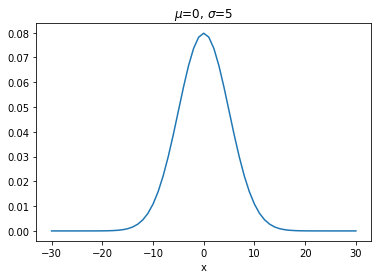

In [10]:
gaussian_kernel , params_gaus = timeSeries.gaussian(x=np.arange(-30,31,1),
                                                                  mu=0,
                                                                  sig=5,
                                                                  plot_pref=True)
spks_conv = timeSeries.convolve_along_axis(spks.T,
                                                         gaussian_kernel,
                                                         axis=0,
                                                         mode='same',
                                                         multicore_pref=True,
                                                         verbose=True)
neural_data = spks_conv[:,IsCell_ROIClassifier==True]

# data exploration

visualize face rhythms output timeseries for regression

In [11]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import decomposition, timeSeries, similarity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


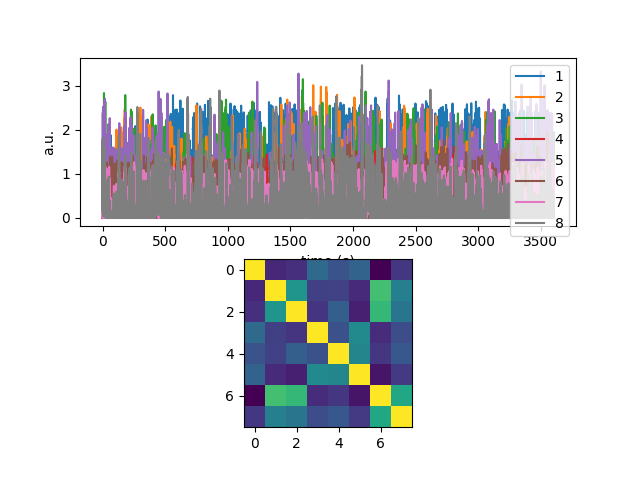

In [12]:
%matplotlib notebook

## just for plotting 
Fs = ops[()]['fs']

fig , axs = plt.subplots(2)
axs[0].plot(np.arange(camSignal_s2pInd.shape[0])/Fs, camSignal_s2pInd);
axs[0].legend(np.arange(camSignal_s2pInd.shape[1])+1)
axs[0].set_xlabel('time (s)')
axs[0].set_ylabel('a.u.')

axs[1].imshow(similarity.pairwise_similarity(camSignal_s2pInd));

### Do PCA

first run PCA on the inputs and outputs to orthogonalize them


look at scree plots and timeSeries of PCs

<IPython.core.display.Javascript object>


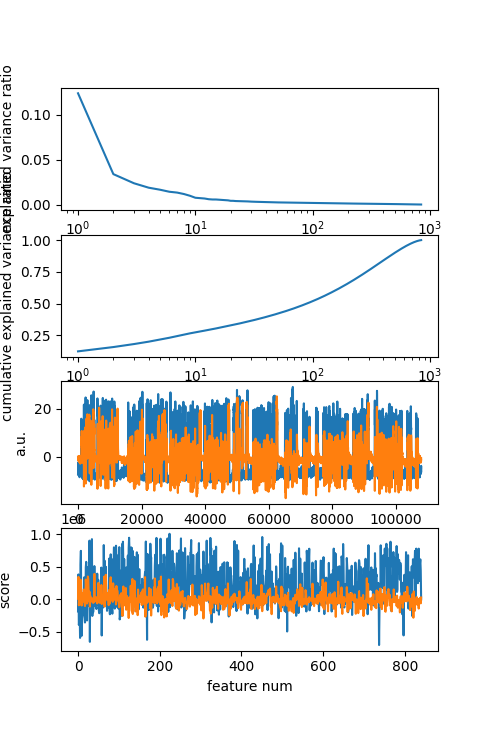

<IPython.core.display.Javascript object>


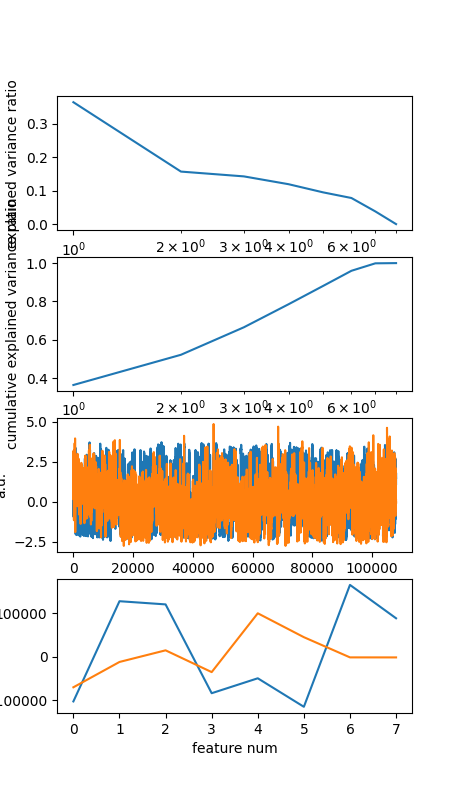

In [13]:
import copy
import scipy.stats

X = copy.deepcopy(scipy.stats.zscore(neural_data[:,:] , axis=0))

PCA_outputs_neural_temporalFactor , PCA_outputs_neural_neuronFactor , EV_ratio_neural = decomposition.simple_pca(X,
                                                                                               n_components=neural_data.shape[1],
                                                                                               plot_pref=True)
X = copy.deepcopy(scipy.stats.zscore(camSignal_s2pInd[:,:] , axis=0))
PCA_outputs_behavioral , PCA_outputs_behavioral_componentFactor , EV_ratio_behavioral = decomposition.simple_pca(X,
                                                                                           n_components=camSignal_s2pInd.shape[1],
                                                                                           plot_pref=True)

In [15]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules.similarity import pairwise_similarity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


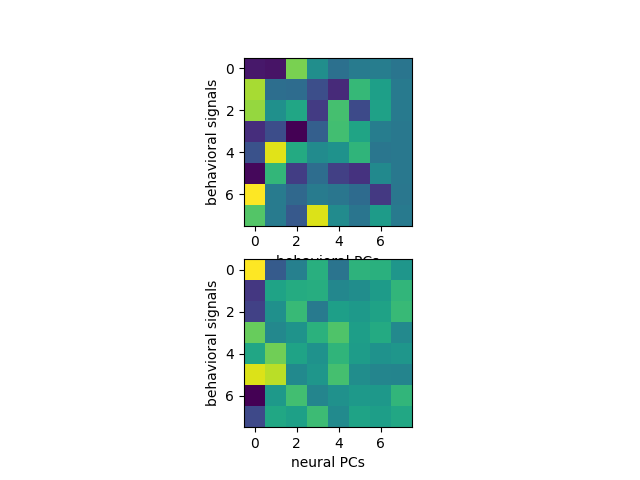

Text(0, 0.5, 'behavioral signals')

In [16]:
fig, axs = plt.subplots(2)
axs[0].imshow(pairwise_similarity(camSignal_s2pInd , PCA_outputs_behavioral))
axs[0].set_xlabel('behavioral PCs')
axs[0].set_ylabel('behavioral signals')
axs[1].imshow(pairwise_similarity(camSignal_s2pInd , PCA_outputs_neural_temporalFactor[:,:8]))
axs[1].set_xlabel('neural PCs')
axs[1].set_ylabel('behavioral signals')

### Run Rastermap

nmin 400
0.26145291328430176
13.04531478881836
13.560484409332275
13.564975261688232
(398, 400)
(148,)
1.0
time; iteration;  explained PC variance
0.39s     0        0.0225      2
0.57s    10        0.1903      9
0.77s    20        0.2521      23
0.94s    30        0.3131      58
1.17s    40        0.3590      93
1.44s    50        0.3955      128
1.62s    60        0.4258      163
1.83s    70        0.4517      198
2.06s    80        0.4771      233
2.40s    90        0.5003      268
2.65s    100        0.5217      303
2.84s    110        0.5419      338
3.09s    120        0.5614      373
3.30s    130        0.5759      398
3.51s    140        0.5759      398
3.67s   final      0.5759
3.67s upsampled    0.5759


<IPython.core.display.Javascript object>


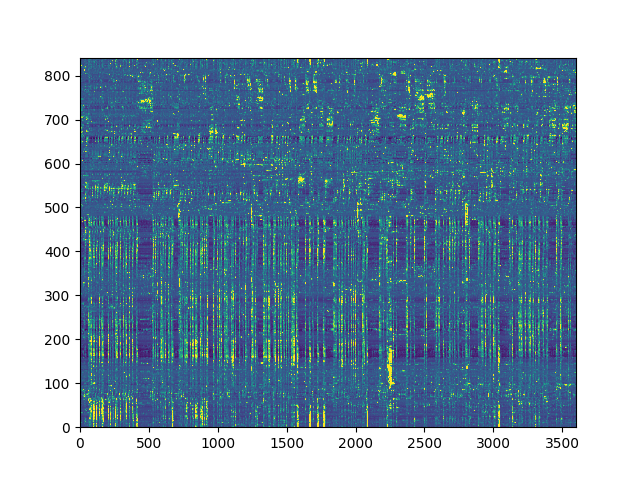

In [17]:
import rastermap.mapping
import copy
import scipy.stats

X = copy.deepcopy(scipy.stats.zscore(neural_data[:,:] , axis=0))

rmap_obj = rastermap.mapping.Rastermap(n_components=1,
                             n_X=400,
                             nPC=400,
                             init='pca',
                             alpha=1.0,
                             K=1.0,
                             mode='basic',
                             verbose=True,
                             annealing=True,
                             constraints=2,)
embedding = rmap_obj.fit_transform(X.T)

fs = ops[()]['fs']
fig, ax = plt.subplots()
ax=plt.imshow(X[:, rmap_obj.isort].T,
              vmin=-1,vmax=2,
              aspect='auto', origin='upper',
              extent=[0,X.shape[0]/fs, 0,X.shape[1]],
              interpolation='antialiased'
             )

# Linear Regression Decoding
`input: TxN` ⟶ `linear regression model` ⟶ `output: Tx1`

In [18]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import plotting_helpers, cross_validation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define inputs and outputs
**can use as either inputs or outputs:**
- neural signals (F, dF, dF/F, spks, spks_conv, etc.)
- neural PCs
- face factors
- face factor PCs
- wavesurfer signals like:
    - ws_licks_bool_S2pInd
    - ws_rewards_bool_S2pInd 
    - ws_treadmill_S2pInd
    
    
**cool ones:**
- face factor PCs to neural PCs & vice-versa: allows for calculation of total explained variance between datasets
- face factor PCs to neurons: allows you to see single neuron explained variance from face factor model
- face factors to neurons: allows you to see single neuron tuning to face factors
- neurons to face factors: allows you to see overlapping populations of neurons for different face factors

**tips:**
- using orthogonalized signals for X greatly increases speed and reduces multi-colinearity issues

In [88]:
import copy

n_behav_traces = camSignal_s2pInd.shape[1]
n_neurons = neural_data.shape[1]
Fs = ops[()]['fs']

# y = copy.deepcopy(np.single(neural_data)) # ROI timeseries
# X = copy.deepcopy(np.single(PCA_outputs_behavioral)) # face rhythm factor PCs
X = copy.deepcopy(np.single(PCA_outputs_neural_temporalFactor)) # neural PCs
y = copy.deepcopy(np.single(camSignal_s2pInd)) # face rhythm factors

### prepare cross-validation

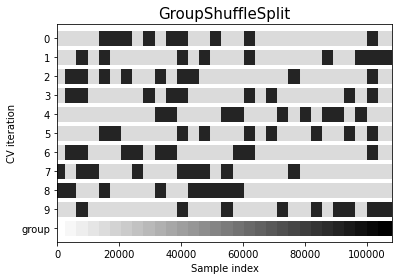

In [104]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)
%matplotlib inline

group_len = 60*2 * Fs # seconds * Fs
n_splits = 10
test_size = 0.3

groups = np.arange(X.shape[0])//group_len
n_groups = np.max(groups)
cv = GroupShuffleSplit(n_splits, test_size=test_size)
cv_idx = cross_validation.make_cv_indices(cv,
                                          groups,
                                          lw=15,
                                          plot_pref=True)

### prepare rolling shuffles

In [105]:
n_nonzero_rolls = 2

min_roll = 60*10*Fs
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_nonzero_rolls)))
n_rolls = n_nonzero_rolls + 1

### prepare regularization params

In [106]:
alphas = np.array([
#     0.0001
#     0.001, 
    0.0005, 
    0.002, 
#     0.004, 
    0.008,
#     0.012, 0.02 ,
    0.02 ,
    0.04 ,
#     0.08 ,
    0.15 ,
#     0.3 ,
    0.45,
    1.5,
#     2.0,
#     4.0,
#     8.0,
#     16,
#     32,
#     64,
#     128
        ])

# alphas = np.array([
#     0.008
# ])

l1_ratios = np.array([
#     1 ,
    0.99,
#     0.95 ,
    0.9,
    0.7,
    0.5, 
    0.2,
    0.1,
    0.05,
    0.02,
    0.01,
                     ])
# l1_ratios = np.array([0])

### perform regression

In [27]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules.linear_regression import LinearRegression_sweep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
# model_params = {
#     'fit_intercept': True,
#     'normalize': False,
# #     'precompute': False,
# #     'copy_X': True,
#     'max_iter': 1000,
#     'tol': 0.0001,
# #     'warm_start': True,
# #     'positive': False,
# #     'random_state': None,
#     'selection': 'cyclic',
# #     'output_type': 'numpy',
# }

model_params_cuml_ElasticNet = {
        'fit_intercept': True,
        'normalize': False,
        'max_iter': 1000,
        'tol': 0.0001,
        'selection': 'cyclic',
#     'handle': None,
#     'output_type': None,
#     'verbose':False,
}

# prepare output variables for in-place computations
n_y = y.shape[1]
n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)
    
theta = np.ones((X.shape[1] , n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
intercept = np.ones((n_y , n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_train  = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))
EV_test   = np.zeros((n_y, n_splits , n_rolls , n_alphas , n_l1Ratios))

# Run regression sweep
theta, intercept, EV_train, EV_test = LinearRegression_sweep(
                                                                X,
                                                                y,
                                                                cv_idx,
                                                                alphas=alphas,
                                                                l1_ratios=l1_ratios,
                                                                rolls=rolls,
                                                                method_package='cuml',
                                                                method_model='ElasticNet',
                                                                verbose=True,
                                                                theta_inPlace=theta, 
                                                                intercept_inPlace=intercept,
                                                                EV_train_inPlace=EV_train,
                                                                EV_test_inPlace=EV_test,
                                                                **model_params_cuml_ElasticNet
)

making cupy arrays
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.812
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.705 

y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.812
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.704 

y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.813
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: 0.701 

y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.813
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: 0.697 

y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.814
y #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: 0.69 

y #: 0 , Roll iter: 0 , CV rep

y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.754
y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.719 

y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.769
y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.721 

y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.8
y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: 0.723 

y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.81
y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: 0.717 

y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.66
y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: 0.652 

y #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ra

y #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.678
y #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.667 

y #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.709
y #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.688 

y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.813
y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.705 

y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.814
y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.704 

y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.814
y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: 0.7 

y #: 0 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005

y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.741
y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.72 

y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.753
y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.723 

y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.77
y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.726 

y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.804
y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: 0.722 

y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.813
y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: 0.71 

y #: 0 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.04 , l1_r

y #: 0 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.613
y #: 0 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.639 

y #: 0 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.67
y #: 0 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.688 

y #: 0 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.703
y #: 0 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.713 

y #: 0 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.822
y #: 0 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.684 

y #: 0 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.822
y #: 0 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.682 

y #: 0 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , 

y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.826
y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.627 

y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.755
y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.667 

y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.76
y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.668 

y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.77
y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.669 

y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.784
y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.67 

y #: 0 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l

y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.587
y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.474 

y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.618
y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.506 

y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.649
y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.539 

y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.696
y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.58 

y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.726
y #: 0 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.612 

y #: 0 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 

y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.353
y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.266 

y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.359
y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.314 

y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.36
y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.333 

y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.224
y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.076 

y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.235
y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.084 

y #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.

y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.287
y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.244 

y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.0
y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.047 

y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.0
y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.047 

y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.0
y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.047 

y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.003
y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.043 

y #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 

y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.353
y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.276 

y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.36
y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.306 

y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.365
y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.34 

y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.372
y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.406 

y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.373
y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.431 

y #: 0 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008

y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.115
y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.058 

y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.224
y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.108 

y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.294
y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.167 

y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.0
y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.002 

y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.0
y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.002 

y #: 0 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio

y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.372
y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.424 

y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.348
y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.293 

y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.351
y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.302 

y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.358
y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.323 

y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.365
y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.347 

y #: 0 , Roll iter: 1 , CV repeat #: 6 , alpha val:

y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.039
y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.028 

y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.055
y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.039 

y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.091
y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.056 

y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.214
y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.145 

y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.285
y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.22 

y #: 0 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_rati

y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.357
y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.416 

y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.358
y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.437 

y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.358
y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.445 

y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.334
y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.256 

y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.337
y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.268 

y #: 0 , Roll iter: 1 , CV repeat #: 9 , alpha 

y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.366
y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.441 

y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.03
y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.009 

y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.036
y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.01 

y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.057
y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.017 

y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.096
y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.038 

y #: 0 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 , l1_r

y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.364
y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.385 

y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.364
y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.396 

y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.365
y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.407 

y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.365
y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.426 

y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.365
y #: 0 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.433 

y #: 0 , Roll iter: 2 , CV repeat #: 2 , alph

y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.279
y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.139 

y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.328
y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.231 

y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.34
y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.29 

y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.026
y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: 0.006 

y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.031
y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: 0.005 

y #: 0 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.04 , l1

y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.353
y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.374 

y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.353
y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.38 

y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.354
y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.392 

y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.354
y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.404 

y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.355
y #: 0 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.425 

y #: 0 , Roll iter: 2 , CV repeat #: 5 , alp

y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.245
y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.075 

y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.279
y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.102 

y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.33
y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.175 

y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.342
y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.217 

y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.018
y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: 0.005 

y #: 0 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.04 

y #: 0 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.035
y #: 0 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.007 

y #: 0 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.095
y #: 0 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.004 

y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.344
y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.325 

y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.344
y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.33 

y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.345
y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.341 

y #: 0 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0

y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.223
y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.2 

y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.237
y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.217 

y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.271
y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.269 

y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.308
y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.349 

y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.359
y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.556 

y #: 0 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0

y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.277
y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.312 

y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.31
y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.353 

y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.389
y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.414 

y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.455
y #: 1 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.437 

y #: 1 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.63
y #: 1 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.305 

y #: 1 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ra

y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.624
y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.22 

y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.625
y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.204 

y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.519
y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.375 

y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.526
y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.372 

y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.545
y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.363 

y #: 1 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 ,

y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.283
y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.274 

y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.317
y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.32 

y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.407
y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.373 

y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.469
y #: 1 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.383 

y #: 1 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.614
y #: 1 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.367 

y #: 1 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.0005 , l1_r

y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.642
y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.223 

y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.643
y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.211 

y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.546
y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.308 

y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.553
y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.304 

y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.571
y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.296 

y #: 1 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 

y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.324
y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.259 

y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.354
y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.281 

y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.42
y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.316 

y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.467
y #: 1 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.335 

y #: 1 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.632
y #: 1 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.227 

y #: 1 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.0005 , l1_r

y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.623
y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.278 

y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.625
y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.27 

y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.518
y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.321 

y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.526
y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.321 

y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.545
y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.32 

y #: 1 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 , 

y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.273
y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.274 

y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.307
y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.3 

y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.343
y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.317 

y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.41
y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.343 

y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.462
y #: 1 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.334 

y #: 1 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.

y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.399
y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.374 

y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.407
y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.454 

y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.408
y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.487 

y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.24
y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.114 

y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.253
y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.124 

y #: 1 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.

y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.306
y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.133 

y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.001
y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.04 

y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.001
y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.04 

y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.001
y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.039 

y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.002
y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.038 

y #: 1 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_rat

y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.396
y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.42 

y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.404
y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.456 

y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.411
y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.498 

y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.417
y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.572 

y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.418
y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.599 

y #: 1 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.00

y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.112
y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.055 

y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.247
y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.155 

y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.328
y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.246 

y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.002
y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.015 

y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.003
y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.015 

y #: 1 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.15 , l1_r

y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.385
y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.393 

y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.355
y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.237 

y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.359
y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.245 

y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.368
y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.266 

y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.375
y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.292 

y #: 1 , Roll iter: 1 , CV repeat #: 7 , alpha val:

y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.027
y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.006 

y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.045
y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.004 

y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.084
y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.001 

y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.214
y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.042 

y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.299
y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.102 

y #: 1 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.15 , l1_rat

y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.411
y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.588 

y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.412
y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.629 

y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.412
y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.644 

y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.383
y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.297 

y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.387
y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.315 

y #: 1 , Roll iter: 2 , CV repeat #: 0 , alpha 

y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.404
y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.332 

y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.047
y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.01 

y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.055
y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.013 

y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.078
y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.022 

y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.113
y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.034 

y #: 1 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_

y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.4
y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.347 

y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.4
y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.365 

y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.401
y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.386 

y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.402
y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.419 

y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.402
y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.431 

y #: 1 , Roll iter: 2 , CV repeat #: 3 , alpha va

y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.343
y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.131 

y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.399
y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.209 

y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.413
y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.257 

y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.045
y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.01 

y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.054
y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.011 

y #: 1 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.04 ,

y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.417
y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.442 

y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.418
y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.448 

y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.418
y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.461 

y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.419
y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.475 

y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.419
y #: 1 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.497 

y #: 1 , Roll iter: 2 , CV repeat #: 6 , al

y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.275
y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.082 

y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.313
y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.091 

y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.372
y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.149 

y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.387
y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.197 

y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.023
y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.002 

y #: 1 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0

y #: 1 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.053
y #: 1 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.006 

y #: 1 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.131
y #: 1 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.011 

y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.408
y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.29 

y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.408
y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.295 

y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.409
y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.307 

y #: 1 , Roll iter: 2 , CV repeat #: 9 , alpha val: 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.528
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.334 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.535
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.335 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.554
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.335 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.576
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.33 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.614
y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: 0.31 

y #: 2 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , 

y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.321
y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.272 

y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.344
y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.287 

y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.417
y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.312 

y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.467
y #: 2 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.323 

y #: 2 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.64
y #: 2 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.099 

y #: 2 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.0005 , l1_r

y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.646
y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.188 

y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.647
y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.173 

y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.533
y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.272 

y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.541
y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.272 

y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.562
y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.272 

y #: 2 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 

y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.301
y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.244 

y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.311
y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.253 

y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.329
y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.27 

y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.356
y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.282 

y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.432
y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.305 

y #: 2 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 

y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.618
y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: 0.326 

y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.624
y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.314 

y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.631
y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.287 

y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.632
y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.274 

y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.513
y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.371 

y #: 2 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 

y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.509
y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: 0.326 

y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.562
y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.311 

y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.28
y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.252 

y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.292
y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.264 

y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.313
y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.288 

y #: 2 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 

y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.605
y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: 0.303 

y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.608
y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: 0.298 

y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.615
y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: 0.282 

y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.622
y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.26 

y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.629
y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.202 

y #: 2 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 ,

y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.136
y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.094 

y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.276
y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.186 

y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.354
y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.253 

y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.0
y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.001 

y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.001
y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.003 

y #: 2 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_rat

y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.447
y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.414 

y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.414
y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.244 

y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.418
y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.254 

y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.428
y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.279 

y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.436
y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.31 

y #: 2 , Roll iter: 1 , CV repeat #: 2 , alpha val: 

y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.065
y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.126 

y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.096
y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.145 

y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.136
y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.188 

y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.267
y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.325 

y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.353
y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.413 

y #: 2 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_rat

y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.443
y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.519 

y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.444
y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.539 

y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.444
y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.546 

y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.416
y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.358 

y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.42
y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.369 

y #: 2 , Roll iter: 1 , CV repeat #: 5 , alpha v

y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.429
y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -1.005 

y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.05
y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.279 

y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.058
y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.29 

y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.083
y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.322 

y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.122
y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.377 

y #: 2 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.04 , l1_r

y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.43
y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.315 

y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.431
y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.327 

y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.432
y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.34 

y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.433
y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.362 

y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.433
y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.37 

y #: 2 , Roll iter: 1 , CV repeat #: 8 , alpha v

y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.375
y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.589 

y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.436
y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.801 

y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.451
y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.934 

y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.06
y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.189 

y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.068
y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.191 

y #: 2 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 ,

y #: 2 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.157
y #: 2 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.08 

y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.427
y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.316 

y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.428
y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.319 

y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.429
y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.327 

y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.429
y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.338 

y #: 2 , Roll iter: 2 , CV repeat #: 1 , alpha v

y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.282
y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.08 

y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.318
y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.105 

y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.358
y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.147 

y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.421
y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.256 

y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.437
y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.327 

y #: 2 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04

y #: 2 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.019
y #: 2 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.006 

y #: 2 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.074
y #: 2 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.029 

y #: 2 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.159
y #: 2 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.059 

y #: 2 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.426
y #: 2 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.303 

y #: 2 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.427
y #: 2 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.308 

y #: 2 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0

y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.43
y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.35 

y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.266
y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.113 

y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.279
y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.121 

y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.311
y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.147 

y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.347
y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.182 

y #: 2 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0

y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.001
y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.018 

y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.004
y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.017 

y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.055
y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.005 

y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.149
y #: 2 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.038 

y #: 2 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.426
y #: 2 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.305 

y #: 2 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 

y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.428
y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.348 

y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.429
y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.368 

y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.265
y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.086 

y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.276
y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.094 

y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.31
y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.118 

y #: 2 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.

y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.006
y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.007 

y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.009
y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.007 

y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.017
y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.008 

y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.069
y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.022 

y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.147
y #: 2 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.05 

y #: 3 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ra

y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.491
y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.341 

y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.511
y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.305 

y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.515
y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.283 

y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.342
y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.364 

y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.351
y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.366 

y #: 3 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 

y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.42
y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.277 

y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.107
y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.075 

y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.118
y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.085 

y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.147
y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.11 

y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.188
y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.139 

y #: 3 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0

y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.497
y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: 0.263 

y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.512
y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: 0.256 

y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.526
y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.245 

y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.545
y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.216 

y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.549
y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.199 

y #: 3 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , 

y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.277
y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: 0.311 

y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.358
y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: 0.337 

y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.414
y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.335 

y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.079
y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.095 

y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.092
y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.109 

y #: 3 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio:

y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.545
y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: 0.015 

y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.484
y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: 0.253 

y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.49
y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: 0.247 

y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.505
y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: 0.23 

y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.521
y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.197 

y #: 3 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 

y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.263
y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: 0.166 

y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.281
y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: 0.177 

y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.306
y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: 0.199 

y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.375
y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: 0.235 

y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.431
y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.24 

y #: 3 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.

y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.299
y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.281 

y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.301
y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.329 

y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.301
y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.348 

y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.228
y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.093 

y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.236
y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.101 

y #: 3 , Roll iter: 1 , CV repeat #: 0 , alpha 

y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.293
y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.254 

y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.002
y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: 0.0 

y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.002
y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: 0.001 

y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.007
y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: 0.001 

y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.015
y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: 0.001 

y #: 3 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio

y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.324
y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.384 

y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.326
y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.401 

y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.328
y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.419 

y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.33
y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.449 

y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.33
y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.46 

y #: 3 , Roll iter: 1 , CV repeat #: 3 , alpha v

y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.164
y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.076 

y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.261
y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.145 

y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.297
y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.206 

y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.001
y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.002 

y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.002
y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.003 

y #: 3 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 

y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.306
y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.284 

y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.307
y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.29 

y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.31
y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.304 

y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.312
y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.32 

y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.314
y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.347 

y #: 3 , Roll iter: 1 , CV repeat #: 6 , alpha

y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.156
y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.103 

y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.249
y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.192 

y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.284
y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.258 

y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.009
y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.011 

y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.011
y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.013 

y #: 3 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 

y #: 3 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.038
y #: 3 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.022 

y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.314
y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.383 

y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.315
y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.393 

y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.318
y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.42 

y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.32
y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.448 

y #: 3 , Roll iter: 1 , CV repeat #: 9 , alpha va

y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.109
y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.082 

y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.138
y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.096 

y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.18
y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.13 

y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.27
y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.236 

y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.302
y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.319 

y #: 3 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.04 ,

y #: 3 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.0
y #: 3 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.003 

y #: 3 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.013
y #: 3 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.003 

y #: 3 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.035
y #: 3 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.003 

y #: 3 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.325
y #: 3 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.285 

y #: 3 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.326
y #: 3 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.293 

y #: 3 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.000

y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.322
y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.402 

y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.102
y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.046 

y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.112
y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.051 

y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.142
y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.068 

y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.182
y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.097 

y #: 3 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0

y #: 3 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.012
y #: 3 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.009 

y #: 3 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.045
y #: 3 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.004 

y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.301
y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.226 

y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.303
y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.234 

y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.305
y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.253 

y #: 3 , Roll iter: 2 , CV repeat #: 5 , alpha val:

y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.087
y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.003 

y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.115
y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.003 

y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.158
y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.004 

y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.254
y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.049 

y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.288
y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.096 

y #: 3 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.04 

y #: 3 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.008
y #: 3 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.052 

y #: 3 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.034
y #: 3 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.045 

y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.322
y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.25 

y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.323
y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.258 

y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.325
y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.275 

y #: 3 , Roll iter: 2 , CV repeat #: 8 , alpha val: 

y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.101
y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.056 

y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.131
y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.071 

y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.169
y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.093 

y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.257
y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.18 

y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.291
y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.262 

y #: 3 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.04

y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.123
y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.126 

y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.196
y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.202 

y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.258
y #: 4 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.23 

y #: 4 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.436
y #: 4 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.106 

y #: 4 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.436
y #: 4 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.102 

y #: 4 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.0005 , 

y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.453
y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.083 

y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.32
y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.192 

y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.33
y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.194 

y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.352
y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.196 

y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.379
y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.191 

y #: 4 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , 

y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.113
y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.044 

y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.122
y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.054 

y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.139
y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.076 

y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.218
y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.149 

y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.275
y #: 4 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.179 

y #: 4 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio:

y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.455
y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.132 

y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.462
y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.092 

y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.464
y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.072 

y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.339
y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.206 

y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.347
y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.206 

y #: 4 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.008 

y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.402
y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.184 

y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.107
y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.096 

y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.113
y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.098 

y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.132
y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.109 

y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.156
y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.119 

y #: 4 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio:

y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.45
y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: 0.059 

y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.458
y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: 0.043 

y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.465
y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.023 

y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.473
y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.015 

y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.474
y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.033 

y #: 4 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.008 ,

y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.268
y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: 0.16 

y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.347
y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: 0.159 

y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.402
y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.141 

y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.097
y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.09 

y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.102
y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.094 

y #: 4 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0

y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.345
y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.306 

y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.311
y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.147 

y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.316
y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.156 

y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.326
y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.177 

y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.334
y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.205 

y #: 4 , Roll iter: 1 , CV repeat #: 1 , alpha val:

y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.034
y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.002 

y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.051
y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.006 

y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.078
y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.014 

y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.17
y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.038 

y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.246
y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.077 

y #: 4 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.15 , l1_rati

y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.359
y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.347 

y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.359
y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.369 

y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.36
y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.376 

y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.33
y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.199 

y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.334
y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.208 

y #: 4 , Roll iter: 1 , CV repeat #: 4 , alpha va

y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.321
y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.254 

y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.011
y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.065 

y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.018
y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.067 

y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.035
y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.074 

y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.061
y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.079 

y #: 4 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.04 , l1

y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.362
y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.353 

y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.363
y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.366 

y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.364
y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.379 

y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.364
y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.401 

y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.364
y #: 4 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.409 

y #: 4 , Roll iter: 1 , CV repeat #: 7 , alph

y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.269
y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.125 

y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.331
y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.233 

y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.347
y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.3 

y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.023
y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.025 

y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.028
y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.024 

y #: 4 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.04 , 

y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.35
y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.274 

y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.35
y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.28 

y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.351
y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.294 

y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.352
y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.309 

y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.353
y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.335 

y #: 4 , Roll iter: 2 , CV repeat #: 0 , alpha

y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.264
y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.098 

y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.295
y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.125 

y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.349
y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.23 

y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.364
y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.3 

y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.081
y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.034 

y #: 4 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.04 ,

y #: 4 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.073
y #: 4 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.011 

y #: 4 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.135
y #: 4 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.034 

y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.361
y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.278 

y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.361
y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.283 

y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.362
y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.294 

y #: 4 , Roll iter: 2 , CV repeat #: 3 , alpha val:

y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.214
y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.051 

y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.225
y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.056 

y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.251
y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.074 

y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.283
y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.102 

y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.336
y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.194 

y #: 4 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0

y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.01
y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.001 

y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.023
y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.003 

y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.075
y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.012 

y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.136
y #: 4 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.013 

y #: 4 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.357
y #: 4 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.173 

y #: 4 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0005 ,

y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.346
y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.204 

y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.347
y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.226 

y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.202
y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.002 

y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.212
y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.0 

y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.237
y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.009 

y #: 4 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.00

y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.011
y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.023 

y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.028
y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.025 

y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.091
y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.053 

y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.157
y #: 4 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.09 

y #: 4 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.346
y #: 4 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.259 

y #: 4 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.0005 ,

y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.718
y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.56 

y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.72
y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.555 

y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.629
y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.551 

y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.633
y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.552 

y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.643
y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.552 

y #: 5 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , 

y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.46
y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.391 

y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.501
y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.436 

y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.575
y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.52 

y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.604
y #: 5 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.539 

y #: 5 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.705
y #: 5 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.582 

y #: 5 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.0005 , l1_ra

y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.721
y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.542 

y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.723
y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.535 

y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.631
y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.541 

y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.635
y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.543 

y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.645
y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.544 

y #: 5 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.008 

y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.454
y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.397 

y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.493
y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.438 

y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.568
y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.521 

y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.596
y #: 5 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.549 

y #: 5 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.706
y #: 5 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.593 

y #: 5 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.0005 , l1_

y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.703
y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.616 

y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.705
y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.608 

y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.606
y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.621 

y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.61
y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.623 

y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.622
y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.627 

y #: 5 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.008 ,

y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.435
y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.475 

y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.482
y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.513 

y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.557
y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.572 

y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.587
y #: 5 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.592 

y #: 5 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.696
y #: 5 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.634 

y #: 5 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.0005 , l1_

y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.712
y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.566 

y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.714
y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.555 

y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.62
y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.562 

y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.623
y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.564 

y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.633
y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.568 

y #: 5 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.008 ,

y #: 5 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.002
y #: 5 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.002 

y #: 5 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.032
y #: 5 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.025 

y #: 5 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.074
y #: 5 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.048 

y #: 5 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.307
y #: 5 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.358 

y #: 5 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.308
y #: 5 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.367 

y #: 5 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.0

y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.311
y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.321 

y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.114
y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.017 

y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.125
y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.02 

y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.154
y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.028 

y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.195
y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.048 

y #: 5 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.

y #: 5 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.002
y #: 5 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.007 

y #: 5 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.018
y #: 5 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.015 

y #: 5 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.056
y #: 5 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.029 

y #: 5 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.325
y #: 5 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.302 

y #: 5 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.326
y #: 5 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.31 

y #: 5 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.00

y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.31
y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.34 

y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.119
y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.069 

y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.13
y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.072 

y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.16
y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.083 

y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.2
y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.107 

y #: 5 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.008 ,

y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.0
y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.024 

y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.0
y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.025 

y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.002
y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.026 

y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.03
y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.045 

y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.099
y #: 5 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.077 

y #: 5 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio:

y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.322
y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.303 

y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.336
y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.411 

y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.338
y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.462 

y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.145
y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.052 

y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.156
y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.058 

y #: 5 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0

y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.202
y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.181 

y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.0
y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.081 

y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.0
y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.081 

y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.0
y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.081 

y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.0
y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.081 

y #: 5 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.

y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.29
y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.155 

y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.305
y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.172 

y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.318
y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.195 

y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.333
y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.26 

y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.336
y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.293 

y #: 5 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.008

y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.065
y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.009 

y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.154
y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.03 

y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.237
y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.059 

y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.0
y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: -0.001 

y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.0
y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: -0.001 

y #: 5 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio:

y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.364
y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.33 

y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.315
y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.149 

y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.321
y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.159 

y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.335
y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.183 

y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.347
y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.212 

y #: 5 , Roll iter: 2 , CV repeat #: 4 , alpha val: 

y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.026
y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.013 

y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.036
y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.015 

y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.058
y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.015 

y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.138
y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.031 

y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.221
y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.062 

y #: 5 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.15 , l1_rat

y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.354
y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.441 

y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.355
y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.478 

y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.355
y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.492 

y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.304
y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.233 

y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.31
y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.246 

y #: 5 , Roll iter: 2 , CV repeat #: 7 , alpha v

y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.336
y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.176 

y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.012
y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: 0.003 

y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.017
y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: 0.003 

y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.032
y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: 0.005 

y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.056
y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: 0.003 

y #: 5 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.04 , l1_rat

y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.705
y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.549 

y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.706
y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: 0.545 

y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.707
y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: 0.539 

y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.709
y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: 0.528 

y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.709
y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: 0.523 

y #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val

y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.644
y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.594 

y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.675
y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: 0.578 

y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.691
y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: 0.559 

y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.552
y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: 0.562 

y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.557
y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: 0.567 

y #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.04 , l1_

y #: 6 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.62
y #: 6 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.544 

y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.711
y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.535 

y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.712
y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.533 

y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.713
y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: 0.528 

y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.714
y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: 0.521 

y #: 6 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0

y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.639
y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.558 

y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.648
y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.558 

y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.66
y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.555 

y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.69
y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: 0.544 

y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.705
y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: 0.531 

y #: 6 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.04 , l1_

y #: 6 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.599
y #: 6 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.59 

y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.705
y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.556 

y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.706
y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.554 

y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.707
y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: 0.549 

y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.708
y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: 0.543 

y #: 6 , Roll iter: 0 , CV repeat #: 6 , alpha val: 0

y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.635
y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.561 

y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.643
y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.557 

y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.655
y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.552 

y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.685
y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: 0.529 

y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.7
y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: 0.51 

y #: 6 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.04 , l1_r

y #: 6 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.585
y #: 6 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.538 

y #: 6 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.618
y #: 6 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.555 

y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.696
y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.546 

y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.697
y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.543 

y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.698
y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: 0.535 

y #: 6 , Roll iter: 0 , CV repeat #: 9 , alpha val: 0.00

y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.171
y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.113 

y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.185
y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.123 

y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.225
y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.153 

y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.273
y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.197 

y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.36
y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.303 

y #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.

y #: 6 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.015
y #: 6 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.009 

y #: 6 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.055
y #: 6 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.012 

y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.396
y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.393 

y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.397
y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.4 

y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.399
y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.417 

y #: 6 , Roll iter: 1 , CV repeat #: 2 , alpha val: 0

y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.179
y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.097 

y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.219
y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.132 

y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.266
y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.177 

y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.359
y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.296 

y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.388
y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.376 

y #: 6 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0

y #: 6 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.001
y #: 6 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.002 

y #: 6 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.027
y #: 6 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.009 

y #: 6 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.081
y #: 6 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.033 

y #: 6 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.384
y #: 6 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.325 

y #: 6 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.385
y #: 6 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.332 

y #: 6 , Roll iter: 1 , CV repeat #: 5 , alpha val: 0.0

y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.4
y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.563 

y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.167
y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.176 

y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.182
y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.183 

y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.218
y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.204 

y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.267
y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.25 

y #: 6 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.00

y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.001
y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.029 

y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.002
y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.031 

y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.018
y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.035 

y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.056
y #: 6 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.047 

y #: 6 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.385
y #: 6 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.362 

y #: 6 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.0005 

y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.385
y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.512 

y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.388
y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.56 

y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.152
y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.131 

y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.165
y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.139 

y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.2
y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.164 

y #: 6 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.00

y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.002
y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.007 

y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.003
y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.009 

y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.023
y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.004 

y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.072
y #: 6 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.032 

y #: 6 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.375
y #: 6 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.299 

y #: 6 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.0005 

y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.383
y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.299 

y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.386
y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.338 

y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.152
y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.026 

y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.166
y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.029 

y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.203
y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.037 

y #: 6 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0

y #: 6 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.0
y #: 6 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.004 

y #: 6 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.018
y #: 6 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.008 

y #: 6 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.066
y #: 6 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.001 

y #: 6 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.392
y #: 6 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.292 

y #: 6 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.393
y #: 6 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.298 

y #: 6 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.0005 

y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.393
y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.326 

y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.164
y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.063 

y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.178
y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.07 

y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.214
y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.088 

y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.259
y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.111 

y #: 6 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.

y #: 6 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.023
y #: 6 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.011 

y #: 6 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.071
y #: 6 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.005 

y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.384
y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.338 

y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.385
y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.346 

y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.387
y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.363 

y #: 6 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0

y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.169
y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.032 

y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.204
y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.049 

y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.252
y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.072 

y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.347
y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.159 

y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.375
y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.231 

y #: 6 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0

y #: 6 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.001
y #: 6 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.018 

y #: 6 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.027
y #: 6 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.015 

y #: 6 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.082
y #: 6 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.044 

y #: 7 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.561
y #: 7 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: 0.04 

y #: 7 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.561
y #: 7 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: 0.036 

y #: 7 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.0005

y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.553
y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.15 

y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.412
y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.277 

y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.421
y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.275 

y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.444
y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: 0.269 

y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.475
y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: 0.257 

y #: 7 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 ,

y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.181
y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.188 

y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.189
y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.191 

y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.203
y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.194 

y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.283
y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.219 

y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.356
y #: 7 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: 0.237 

y #: 7 , Roll iter: 0 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio:

y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.57
y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.049 

y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.577
y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.12 

y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.579
y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.15 

y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.442
y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: 0.151 

y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.451
y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: 0.146 

y #: 7 , Roll iter: 0 , CV repeat #: 4 , alpha val: 0.008 

y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.457
y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.274 

y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.173
y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.16 

y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.175
y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.162 

y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.183
y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: 0.168 

y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.194
y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: 0.175 

y #: 7 , Roll iter: 0 , CV repeat #: 5 , alpha val: 0.15 , l1_ratio: 

y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.531
y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: 0.195 

y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.541
y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: 0.182 

y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.549
y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: 0.165 

y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.558
y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: 0.12 

y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.56
y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: 0.1 

y #: 7 , Roll iter: 0 , CV repeat #: 7 , alpha val: 0.008 , l1_r

y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.342
y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: 0.21 

y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.443
y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: 0.203 

y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.504
y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: 0.169 

y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.99 , train R^2: 0.186
y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.99 , test  R^2: 0.155 

y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.9 , train R^2: 0.189
y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.9 , test  R^2: 0.157 

y #: 7 , Roll iter: 0 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 

y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.4
y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.475 

y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.365
y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.283 

y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.37
y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.294 

y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.7 , train R^2: 0.38
y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.7 , test  R^2: -0.322 

y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.5 , train R^2: 0.388
y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.002 , l1_ratio: 0.5 , test  R^2: -0.354 

y #: 7 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.0

y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.014
y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.022 

y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.03
y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.027 

y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.067
y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.041 

y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.2 , train R^2: 0.206
y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.2 , test  R^2: -0.113 

y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.1 , train R^2: 0.308
y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.04 , l1_ratio: 0.1 , test  R^2: -0.195 

y #: 7 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.15 , l1_rati

y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.397
y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.296 

y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.397
y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.32 

y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.397
y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.329 

y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.99 , train R^2: 0.362
y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.99 , test  R^2: -0.164 

y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.9 , train R^2: 0.367
y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha val: 0.002 , l1_ratio: 0.9 , test  R^2: -0.171 

y #: 7 , Roll iter: 1 , CV repeat #: 3 , alpha v

y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.376
y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.213 

y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.011
y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.054 

y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.014
y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.056 

y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.7 , train R^2: 0.023
y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.7 , test  R^2: -0.058 

y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.5 , train R^2: 0.046
y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1_ratio: 0.5 , test  R^2: -0.061 

y #: 7 , Roll iter: 1 , CV repeat #: 4 , alpha val: 0.04 , l1

y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.398
y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.418 

y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.399
y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.431 

y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.399
y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.445 

y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.2 , train R^2: 0.4
y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.2 , test  R^2: -0.467 

y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.1 , train R^2: 0.4
y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha val: 0.0005 , l1_ratio: 0.1 , test  R^2: -0.475 

y #: 7 , Roll iter: 1 , CV repeat #: 6 , alpha va

y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.305
y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.144 

y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.38
y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.225 

y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.399
y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.281 

y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.99 , train R^2: 0.01
y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.99 , test  R^2: -0.008 

y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.9 , train R^2: 0.014
y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , l1_ratio: 0.9 , test  R^2: -0.009 

y #: 7 , Roll iter: 1 , CV repeat #: 7 , alpha val: 0.04 , 

y #: 7 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.099
y #: 7 , Roll iter: 1 , CV repeat #: 8 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.086 

y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.405
y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.493 

y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.405
y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.501 

y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.406
y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.518 

y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.5 , train R^2: 0.407
y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha val: 0.0005 , l1_ratio: 0.5 , test  R^2: -0.536 

y #: 7 , Roll iter: 1 , CV repeat #: 9 , alpha 

y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.229
y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.121 

y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.261
y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.148 

y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.297
y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.195 

y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.362
y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.315 

y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.1 , train R^2: 0.379
y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0.1 , test  R^2: -0.403 

y #: 7 , Roll iter: 2 , CV repeat #: 0 , alpha val: 0.0

y #: 7 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.045
y #: 7 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: 0.01 

y #: 7 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.101
y #: 7 , Roll iter: 2 , CV repeat #: 1 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.014 

y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.384
y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.252 

y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.385
y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.257 

y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.7 , train R^2: 0.386
y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0.0005 , l1_ratio: 0.7 , test  R^2: -0.268 

y #: 7 , Roll iter: 2 , CV repeat #: 2 , alpha val: 0

y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.222
y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.091 

y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.235
y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.099 

y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.268
y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.121 

y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.307
y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.154 

y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.2 , train R^2: 0.371
y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0.008 , l1_ratio: 0.2 , test  R^2: -0.224 

y #: 7 , Roll iter: 2 , CV repeat #: 3 , alpha val: 0

y #: 7 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.041
y #: 7 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.039 

y #: 7 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.061
y #: 7 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.07 

y #: 7 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.112
y #: 7 , Roll iter: 2 , CV repeat #: 4 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.068 

y #: 7 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.408
y #: 7 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.371 

y #: 7 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , train R^2: 0.409
y #: 7 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.0005 , l1_ratio: 0.9 , test  R^2: -0.378 

y #: 7 , Roll iter: 2 , CV repeat #: 5 , alpha val: 0.00

y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.403
y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.457 

y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.219
y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.08 

y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.232
y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.09 

y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.268
y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.118 

y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , train R^2: 0.311
y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.008 , l1_ratio: 0.5 , test  R^2: -0.163 

y #: 7 , Roll iter: 2 , CV repeat #: 6 , alpha val: 0.0

y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , train R^2: 0.008
y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.7 , test  R^2: -0.009 

y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.5 , train R^2: 0.011
y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.5 , test  R^2: -0.004 

y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , train R^2: 0.051
y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.2 , test  R^2: -0.009 

y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , train R^2: 0.122
y #: 7 , Roll iter: 2 , CV repeat #: 7 , alpha val: 0.15 , l1_ratio: 0.1 , test  R^2: -0.052 

y #: 7 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , train R^2: 0.406
y #: 7 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 , l1_ratio: 0.99 , test  R^2: -0.396 

y #: 7 , Roll iter: 2 , CV repeat #: 8 , alpha val: 0.0005 

y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , train R^2: 0.398
y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.2 , test  R^2: -0.346 

y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.1 , train R^2: 0.399
y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.002 , l1_ratio: 0.1 , test  R^2: -0.373 

y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , train R^2: 0.21
y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.99 , test  R^2: -0.086 

y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , train R^2: 0.224
y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.9 , test  R^2: -0.094 

y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , train R^2: 0.256
y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.008 , l1_ratio: 0.7 , test  R^2: -0.111 

y #: 7 , Roll iter: 2 , CV repeat #: 9 , alpha val: 0.

### save regression output

In [108]:
# save regression outputs

cv_params = {
                    "rolls": rolls,
                    "group_len": group_len,
                    "groups": groups,
                    "n_groups": n_groups,
                    "n_splits": n_splits,
                    "test_size": test_size,
                    "min_roll": min_roll,
                    "cv_idx": cv_idx
}

regression_run = {
                    "alphas": alphas,
                    "l1_ratios": l1_ratios,
                    "IsCell_ROIClassifier": IsCell_ROIClassifier,
                    "X": X,
                    "y": y,
                    "theta":theta,
                    "intercept":intercept,
                    "EV_train": EV_train,
                    "EV_test": EV_test,
                    "cv_params": cv_params,
}


from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_save = 'regression_run_'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , regression_run)
# import joblib
# joblib.dump(regression_run , path_save, protocol=4)

Saving to: /media/rich/bigSSD/analysis_data/mouse 2_6/20210417/postHoc_analysis/regression_run_20210517.npy


### load regression output

## plotting

### simple plotting

In [169]:
import scipy.signal
%matplotlib notebook
plt.figure()
plt.plot(np.max(np.median(EV_test[:,:,0,:,:], axis=1), axis=(1,2)))
plt.xlabel('y #')
plt.ylabel('best $R^2$')
# plt.plot(scipy.signal.savgol_filter(EV_test_mean,31,3))
# print(f'total explained variance: {np.sum(EV_test_mean)}')
# plt.xscale('log')

bins = np.arange(0,0.6,0.02)
counts , edges = np.histogram(EV_test_mean, bins)
edges_centers = (edges[:-1] + edges[1:]) / 2
fig , axs = plt.subplots(1)
axs.fill_between(edges_centers , (counts/len(EV_test_mean))*100 , step="post", alpha=0.5)
axs.set_ylabel('percentage of counts')
axs.set_xlabel('$R^2$')
axs.set_yscale('log')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### plot output with 0-1 hyperparameters (LinearRegression - Lasso, Ridge)

<IPython.core.display.Javascript object>


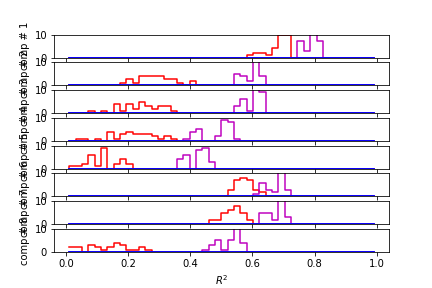

In [170]:
import numpy
alf = np.array([0,1,2])
l1R = 3

n_bins = 50
ylim = [0, 10]
n_rolls = len(rolls)

%matplotlib notebook
fig, axs = plt.subplots(n_y, sharex=True, sharey=True)
# comps_toUse = np.arange(20)
comps_toUse = np.arange(n_y)
for i_comp, comp in enumerate(comps_toUse):

    for i_shuf,vals in enumerate(np.arange(n_rolls)):
#         data = EV_test[comp,:,i_shuf,alf,l1R]**2
        data = EV_test[comp,:,i_shuf,alf,l1R]
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'r')
        else:
            axs[i_comp].step(edges_centers , counts , 'b')
        
#         data = EV_train[comp,:,i_shuf,alf,l1R]**2
        data = EV_train[comp,:,i_shuf,alf,l1R]
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2
        
        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'm')
#         else:
#             axs[i_comp].step(edges_centers , counts , 'c')
        
        plt.xlabel('$R^2$')
        axs[i_comp].set_ylabel(f'comp # {comp+1}')
        axs[i_comp].set_ylim(ylim)
#         axs.subplot(sharey = ax1)
#         plt.legend(('test','train','test shuffle','train shuffle'))


### plot output with 1 hyperparameters (Lasso, Ridge)

<IPython.core.display.Javascript object>


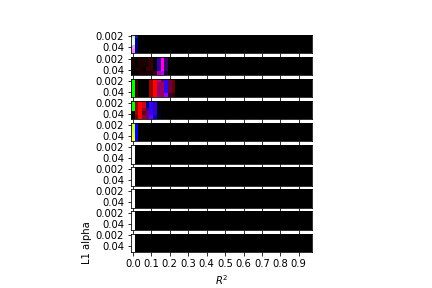

<ipython-input-83-c56b7076da8f>:35: RuntimeWarning: invalid value encountered in true_divide
  im_norm[:,:,1] = im[:,:,1] / np.max(im[:,:,1])


In [83]:
n_alphas = EV_test.shape[3]
n_fac = EV_test.shape[0]
n_fac = 10

im = np.zeros((n_alphas, len(edges_centers),3))

fig, axs = plt.subplots(n_fac, sharex=True, sharey=False)

for i_fac in range(n_fac):

    for alf in range(n_alphas):
        data = EV_test[i_fac,:,0,alf,0]
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,0] = counts

        data = EV_test[i_fac,:,1,alf,0]
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,1] = counts
        
        data = EV_train[i_fac,:,0,alf,0]
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,2] = counts

    im_norm = np.zeros((n_alphas, len(edges_centers),3))
    im_norm[:,:,0] = im[:,:,0] / np.max(im[:,:,0])
    im_norm[:,:,1] = im[:,:,1] / np.max(im[:,:,1])
    im_norm[:,:,2] = im[:,:,2] / np.max(im[:,:,2])
    axs[i_fac].imshow(im_norm)
    
    ticks_toUse = np.arange(0,len(edges_centers) , 5)
    axs[i_fac].set_xticks(ticks_toUse)
    axs[i_fac].set_xticklabels(np.round(edges_centers[ticks_toUse],1))
    
    ticks_toUse = np.arange(0,n_alphas ,3)    
    axs[i_fac].set_yticks(ticks_toUse)
    axs[i_fac].set_yticklabels(np.round(alphas[ticks_toUse],3))
    
    plt.xlabel('$R^2$')
    plt.ylabel('L1 alpha')

### plot output with 2 hyperparameters (ElasticNet)

<IPython.core.display.Javascript object>


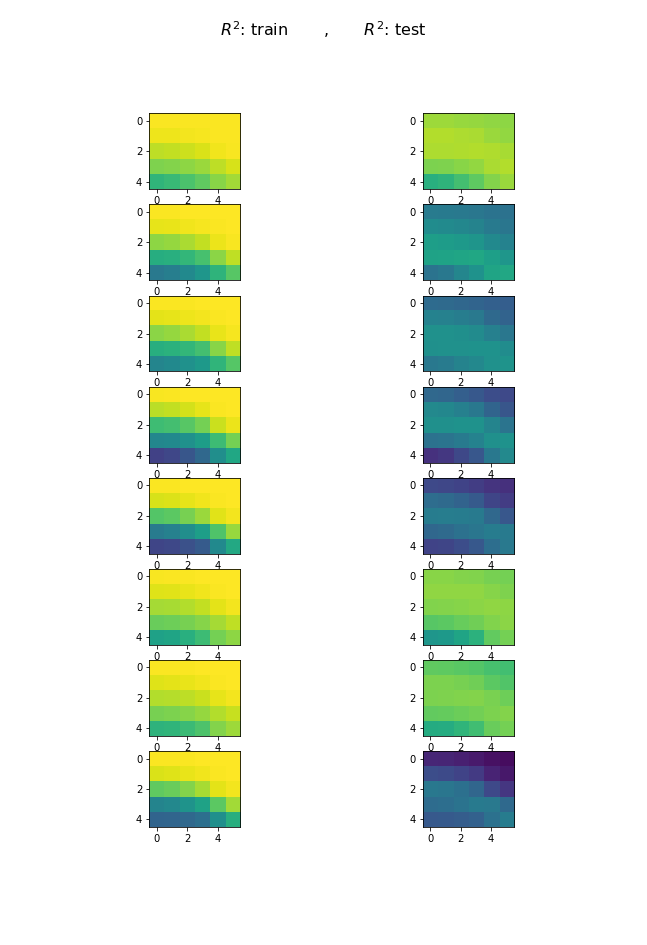

<IPython.core.display.Javascript object>


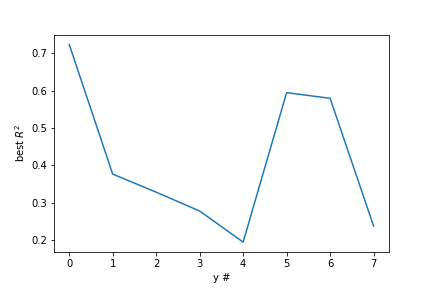

<IPython.core.display.Javascript object>


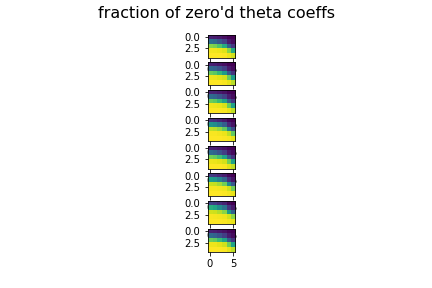

In [163]:
%matplotlib notebook

fig, axs = plt.subplots(n_y,2)
fig.suptitle("$R^2$: train       ,       $R^2$: test", fontsize=16)
for ii in range(n_y):
    axs[ii,0].imshow(np.median(EV_train[ii,:,0,:,:], axis=0),
                                  vmin=0,vmax=np.max(np.mean(EV_train[ii,:,0,:,:], axis=0)) )
#                                   vmin=0,vmax=1 )
    axs[ii,1].imshow(np.median(EV_test[ii,:,0,:,:], axis=0),
                                  vmin=0,vmax=np.max(np.mean(EV_train[ii,:,0,:,:], axis=0)) )

plt.figure()
plt.plot(np.max(np.median(EV_test[:,:,0,:,:], axis=1), axis=(1,2)))
plt.xlabel('y #')
plt.ylabel('best $R^2$')

fig, axs = plt.subplots(n_y)
fig.suptitle("fraction of zero'd theta coeffs", fontsize=16)
for ii in range(n_y):
    axs[ii].imshow(np.median(np.sum(theta[:,ii,:,0,:,:]==0, axis=0), axis=0) / theta.shape[0])

<IPython.core.display.Javascript object>


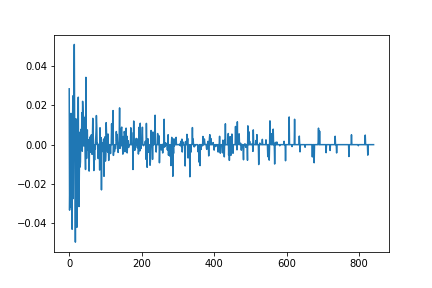

In [164]:
plt.figure()
plt.plot(theta[:,0,0,0,3,5])

## Explained variance and orthogonalization analysis

In [400]:
%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules.similarity import proj, orthogonalize, OLS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
X = copy.deepcopy(scipy.stats.zscore(neural_data[:,:] , axis=0))

# v1 = X[:,rmap_obj.isort[neuron_toTest]]
v1 = X[:,rmap_obj.isort[:]]
# v2 = PCA_outputs_neural_temporalFactor[:,:5]
v2 = camSignal_s2pInd

# proj_vec, proj_score = proj(X[:,rmap_obj.isort[neuron_toTest]], PCA_outputs_neural_temporalFactor[:,0])
v1_orth, v2_PCs, EVR, EVR_total = orthogonalize(v1, PCA_outputs_neural_temporalFactor[:,:1])
v1_orth2, v2_PCs2, EVR2, EVR_total2 = orthogonalize(v1, camSignal_s2pInd[:,:])

# plt.figure()
# plt.plot(v2)
# plt.plot(v1)
# # plt.plot(PCA_outputs_neural_temporalFactor[:,0])
# plt.plot(v1_orth)

print(f'EVR_total: {EVR_total}')
print(f'EVR_total: {EVR_total2}')

plt.figure()
plt.plot(EVR)
plt.plot(EVR2)
# plt.plot(EVR2/EVR)

Text(0, 0.5, 'EV: face factors 8 factors)')

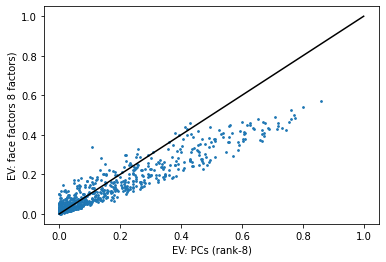

In [1332]:
plt.figure()
plt.scatter(EVR, EVR2 , s=3)
plt.plot(np.array([0,1]), np.array([0,1]) , 'k')
# plt.title(f')
plt.xlabel(f'EV: PCs (rank-{8})')
plt.ylabel(f'EV: face factors {8} factors)')

<IPython.core.display.Javascript object>


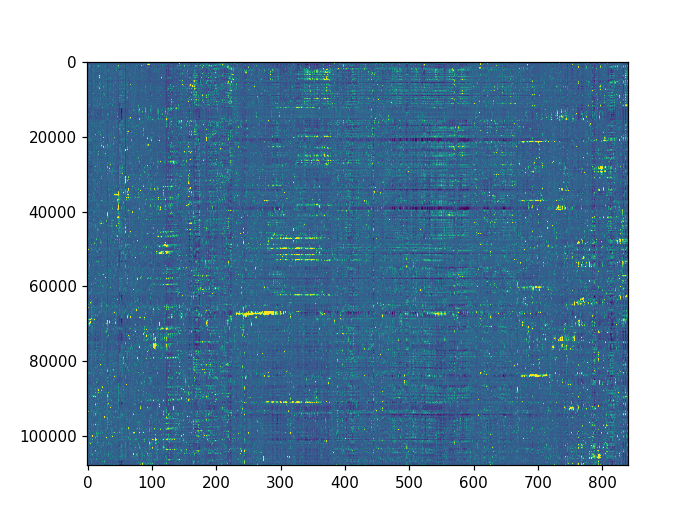

In [337]:
plt.figure()
plt.imshow(v1_orth, aspect='auto', vmin=-1, vmax=2)

### extras

treadmill, train R: 0.8822762507831636
treadmill, test  R: 0.8772212840377442
R^2: 0.7695171811688287


<IPython.core.display.Javascript object>


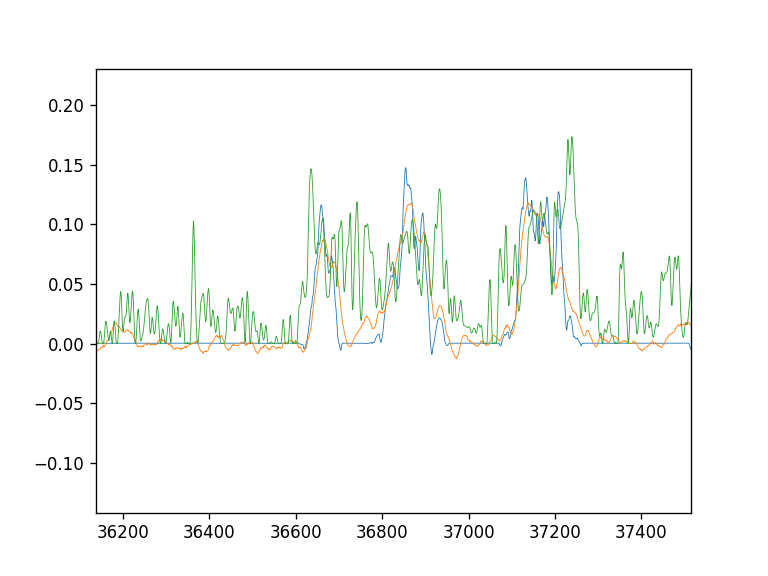

In [61]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,7]/10 , linewidth = 0.5)

treadmill, train R: 0.8471622646934773
treadmill, test  R: 0.8401484750669375


<IPython.core.display.Javascript object>


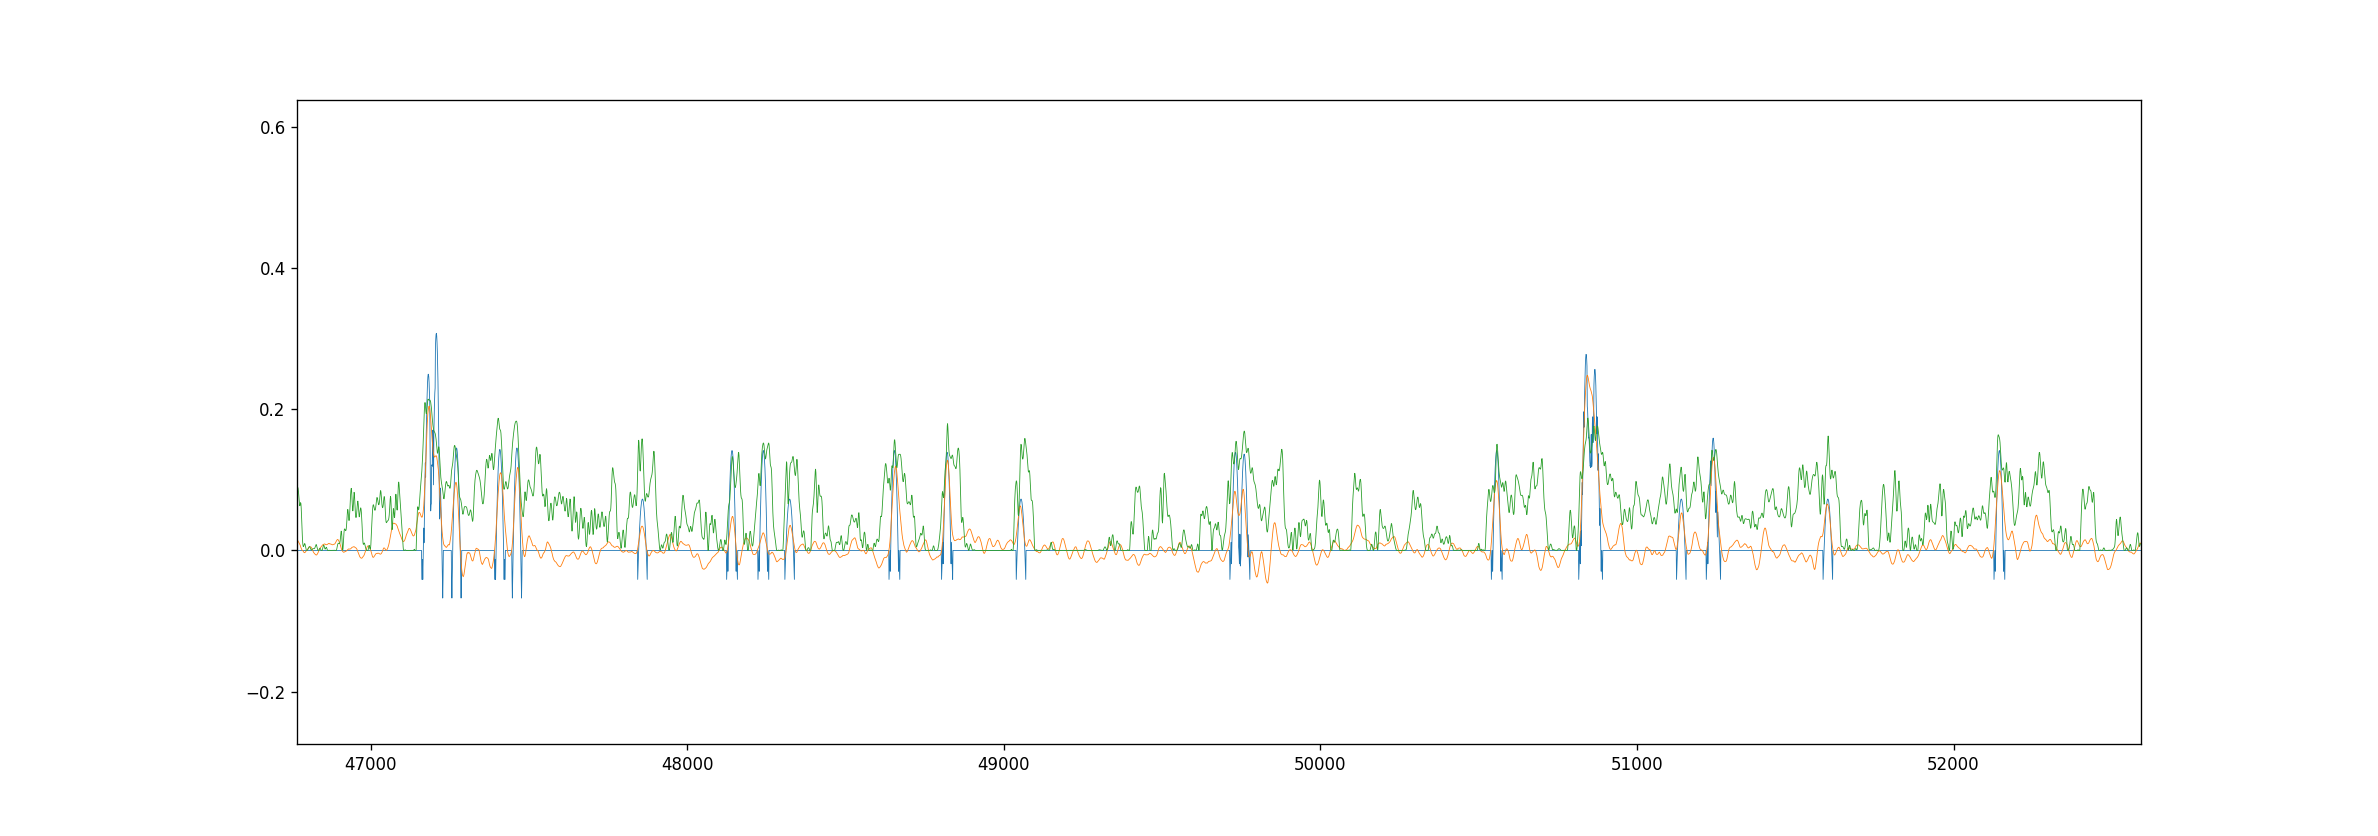

In [37]:
## Correlate to licking signal
# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = spks[IsCell_ROIClassifier==True,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,2]/10 , linewidth = 0.5)